In [1]:
# =============================
# eICU Age Distribution GAN
# =============================

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# 1. Load data
# -----------------------------
working_data = np.load("eICU_age.npy")   # Structured array with field 'age'
age_values = working_data["age"]         # Extract numeric column

print(f"Loaded {len(age_values)} ages. Mean={np.mean(age_values):.2f}, Std={np.std(age_values):.2f}")

# -----------------------------
# 2. Normalize data to [-1, 1]
# -----------------------------
ages = (age_values - age_values.min()) / (age_values.max() - age_values.min()) * 2 - 1
ages = ages.astype(np.float32)

# Convert to PyTorch tensor for GAN training
data = torch.tensor(ages).unsqueeze(1)
loader = DataLoader(TensorDataset(data), batch_size=64, shuffle=True)

Loaded 2520 ages. Mean=63.28, Std=17.72


In [2]:
# -----------------------------
# 2. Define Generator and Discriminator
# -----------------------------
latent_dim = 16  # noise dimension

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(0.2),
            nn.Linear(32, 32),
            nn.ReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Initialize models
G = Generator()
D = Discriminator()

In [3]:
# -----------------------------
# 3. Optimizers and Loss
# -----------------------------
lr = 0.0001
criterion = nn.BCELoss()
optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = optim.RMSprop(D.parameters(), lr=lr)

In [4]:
# -----------------------------
# 4. Training loop
# -----------------------------
epochs = 300
loss_G, loss_D = [], []

for epoch in range(epochs):
    for real_batch, in loader:
        batch_size = real_batch.size(0)

        # Ground truth labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # --- Train Discriminator ---
        z = torch.randn(batch_size, latent_dim)
        fake_data = G(z).detach()

        D_real = D(real_batch)
        D_fake = D(fake_data)

        loss_real = criterion(D_real, real_labels)
        loss_fake = criterion(D_fake, fake_labels)
        d_loss = (loss_real + loss_fake) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        z = torch.randn(batch_size, latent_dim)
        fake_data = G(z)
        D_fake = D(fake_data)
        g_loss = criterion(D_fake, real_labels)  # want D(fake)=1

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    loss_D.append(d_loss.item())
    loss_G.append(g_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

Epoch [100/300]  D_loss: 0.6914  G_loss: 0.6946
Epoch [200/300]  D_loss: 0.6861  G_loss: 0.6874
Epoch [300/300]  D_loss: 0.6917  G_loss: 0.6927


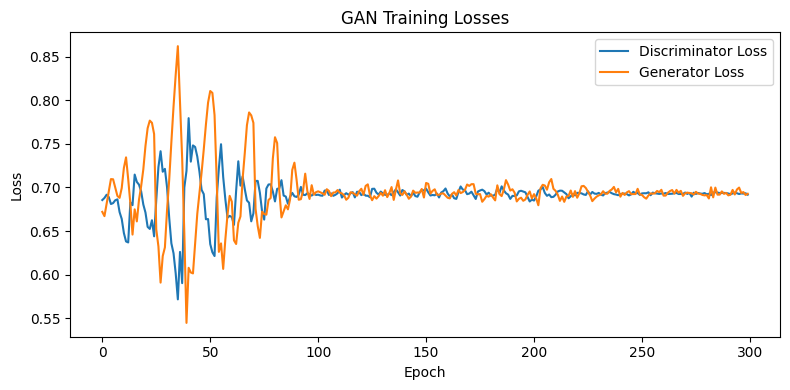

In [5]:
# -----------------------------
# 5. Plot training losses
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_D, label="Discriminator Loss")
plt.plot(loss_G, label="Generator Loss")
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


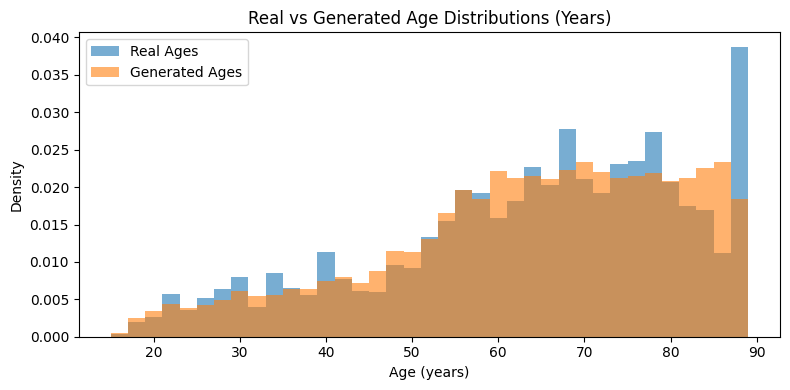

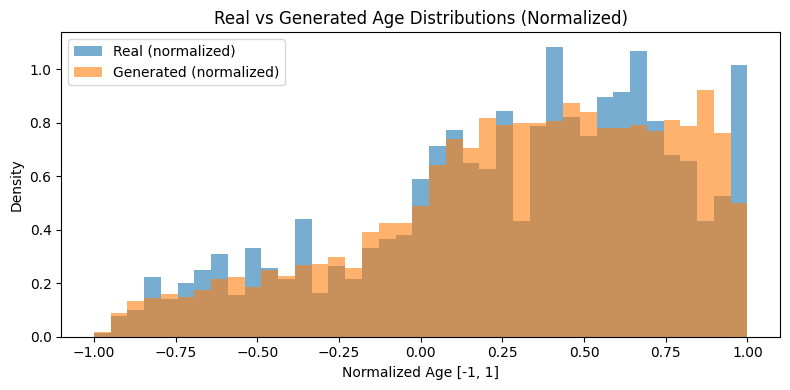

In [6]:
# -----------------------------
# 6. Compare real vs generated distributions
# (normalized and original years)
# -----------------------------

# Use original scale bounds from the raw ages
age_min, age_max = age_values.min(), age_values.max()

def denorm(x):
    """Map from [-1, 1] back to original age scale [age_min, age_max]."""
    return (x + 1.0) * 0.5 * (age_max - age_min) + age_min

# Sample generator outputs (normalized in [-1, 1])
G.eval()
with torch.no_grad():
    z = torch.randn(10000, latent_dim)
    synth_norm = G(z).cpu().numpy().squeeze()   # [-1, 1]

# Prepare both normalized and real-scale arrays
real_norm  = ages.astype(np.float32).squeeze()  # your normalized real ages in [-1, 1]
synth_age  = denorm(synth_norm)                 # years
real_age   = age_values.astype(float)           # years

# ---------- 6.1 Plot in ORIGINAL YEARS ----------
plt.figure(figsize=(8, 4))
bins_years = np.arange(min(real_age.min(), synth_age.min()),
                       max(real_age.max(), synth_age.max()) + 1, 2)  # 2-year bins
plt.hist(real_age,  bins=bins_years, density=True, alpha=0.6, label="Real Ages")
plt.hist(synth_age, bins=bins_years, density=True, alpha=0.6, label="Generated Ages")
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.title("Real vs Generated Age Distributions (Years)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 6.2 (Optional) Plot in NORMALIZED SCALE ----------
plt.figure(figsize=(8, 4))
bins_norm = np.linspace(-1, 1, 40)
plt.hist(real_norm,  bins=bins_norm, density=True, alpha=0.6, label="Real (normalized)")
plt.hist(synth_norm, bins=bins_norm, density=True, alpha=0.6, label="Generated (normalized)")
plt.xlabel("Normalized Age [-1, 1]")
plt.ylabel("Density")
plt.title("Real vs Generated Age Distributions (Normalized)")
plt.legend()
plt.tight_layout()
plt.show()